# Inversion of ERT transects

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from resipy import Project

ERTdatadir = 'data/ERT/'

In [16]:
# Parameters
extract = 0.5 # 0.5 and 2.5

## Middelkerke

In [17]:
# reading electrode position
dfm = pd.read_csv(ERTdatadir + 'electrode_locations_Middelkerke.csv')
elec = np.zeros((120, 3))
elec[:, 0] = dfm['distance'].values
dfm.head()

,ID,distance,easting,northing
0,1,0.0,41665.091,204320.014
1,2,0.5,41665.283,204319.552
2,3,1.0,41665.475,204319.091
3,4,1.5,41665.667,204318.629
4,5,2.0,41665.858,204318.167


Working directory is: c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\resipy
clearing dirname
filterData: 0 / 1693 quadrupoles removed.
308/1693 reciprocal measurements found.
32 measurements error > 20 %
19 measurements outside [0,6183.725257533959] removed!
filterData: 29 / 1674 quadrupoles removed.
29 measurements with greater than 20.0% reciprocal error removed!
Error model is R_err = 0.005 R_avg^0.577 (R^2 = 0.758)
Creating triangular mesh...done (73189 elements)


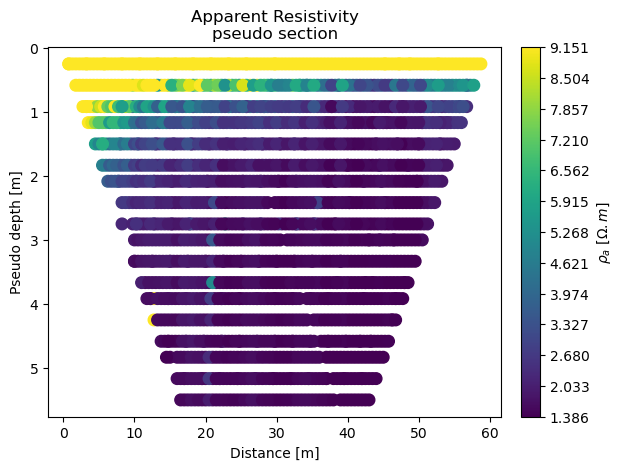

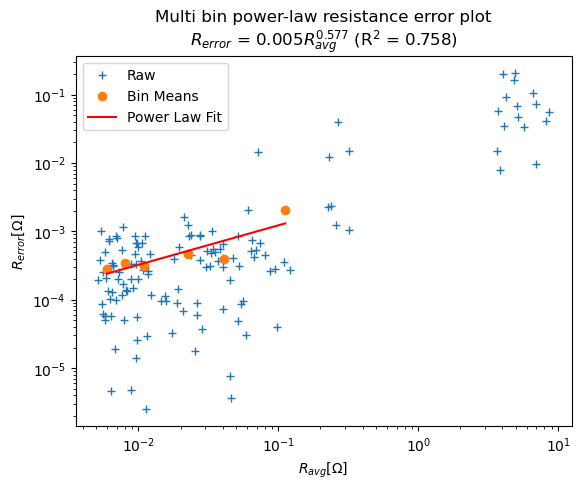

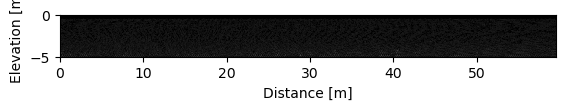

In [18]:
# invert
km = Project()
km.createSurvey(ERTdatadir + '23082301.csv', ftype='Syscal')
km.setElec(elec)
km.filterAppResist(vmin=0)
km.showPseudo()
km.filterRecip() 
km.fitErrorPwl()
km.createMesh('trian')
km.showMesh()

In [19]:
# invert
km.err = True  # use fitted error in the inversion
km.invert()

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 23 - 10 - 2024
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<
 >> D a t a   w e i g h t   t o   b e   r e a d   f r o m   d a t a   f i l e <<


 Processing dataset   1


 Measurements read:  1507     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.24142E+01

 

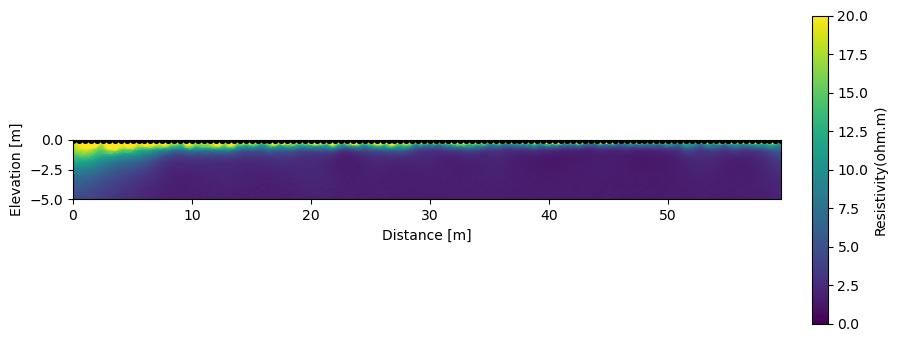

In [20]:
# inverted transect
fig, ax = plt.subplots(figsize=(10, 4))
km.showResults(ax=ax, sens=False, attr='Resistivity(ohm.m)', vmin=0, vmax=20)

fig.savefig(ERTdatadir + 'middelkerke-inv-ERT-'+'.jpg', dpi=300)

In [21]:
# extract profiles
m_m = km.meshResults[0]

dfs = []
for i in range(dfm.shape[0]):
    row = dfm.loc[i, :]
    ie = m_m.df['X'].between(row['distance'] - extract, row['distance'] + extract) & m_m.df['Z'].gt(-5) # 0.5 and 2.5
    sdf = m_m.df[ie][['Z', 'Resistivity(ohm.m)']]
    sdf['Z'] = sdf['Z'].round(1)
    #sdf['Z'] = (sdf['Z'] * 2).round(1) / 2
    sdf = sdf.groupby('Z').mean().reset_index()
    sdf['easting'] = row['easting']
    sdf['northing'] = row['northing']
    sdf['ID'] = row['ID']
    dfs.append(sdf)
dfmi = pd.concat(dfs)

dfmi.to_csv(ERTdatadir + 'middelkerke-inv-ERT-'+str(extract)+'.csv', index=False)

C:\Users\gmendoza\AppData\Local\Temp\ipykernel_23972\411089821.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.plot(dfmi[ie]['Resistivity(ohm.m)'], dfmi[ie]['Z'], '-')


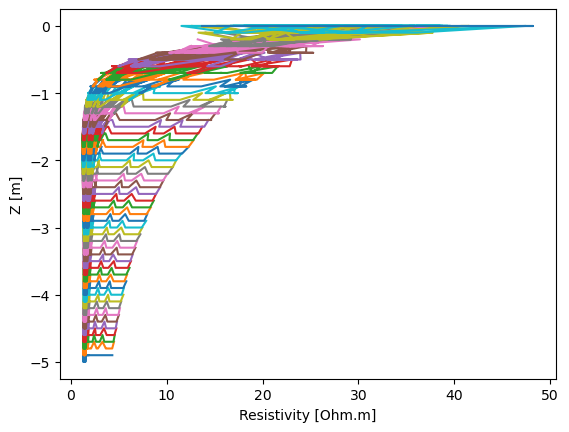

In [22]:
# figure of profiles
fig, ax = plt.subplots()
for el in dfm['ID'].unique():
    ie = dfm['ID'].eq(el)
    ax.plot(dfmi[ie]['Resistivity(ohm.m)'], dfmi[ie]['Z'], '-')
ax.set_xlabel('Resistivity [Ohm.m]')
ax.set_ylabel('Z [m]')
fig.savefig(ERTdatadir + 'middelkerke-prof'+str(extract)+'.jpg')

## Proefhoeve

In [23]:
# reading electrode position
dfp = pd.read_csv(ERTdatadir + 'electrode_locations_Proefhoeve.csv')
dfp = dfp[:-1]
elec = np.zeros((60, 3))
elec[:, 0] = dfp['distance'].values
dfp.head()

,ID,distance,easting,northing
0,1,30.0,107761.108,183310.609
1,2,29.5,107761.387,183310.199
2,3,29.0,107761.668,183309.785
3,4,28.5,107761.949,183309.372
4,5,28.0,107762.230,183308.958


Working directory is: c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\resipy
clearing dirname
filterData: 0 / 993 quadrupoles removed.
182/993 reciprocal measurements found.
4 measurements error > 20 %
3 measurements outside [0,74.02322483964478] removed!
filterData: 4 / 990 quadrupoles removed.
4 measurements with greater than 20.0% reciprocal error removed!
Error model is R_err = 0.012 R_avg^1.444 (R^2 = 0.963)
Creating triangular mesh...done (25688 elements)


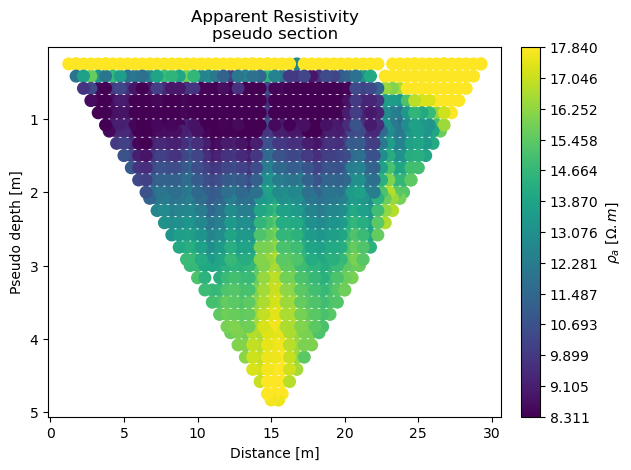

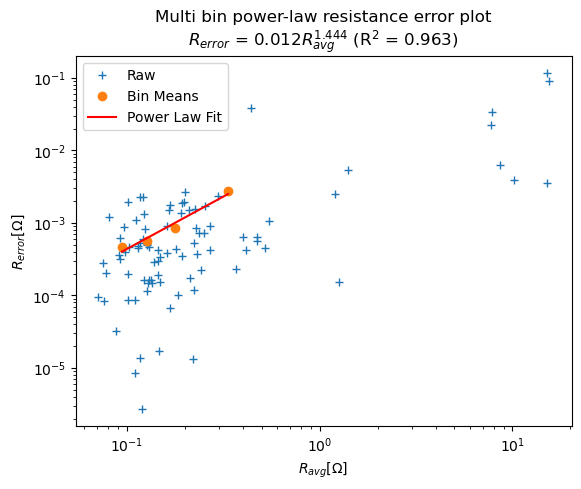

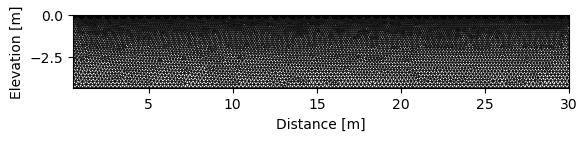

In [24]:
kp = Project()
kp.createSurvey(ERTdatadir + '23082201.csv', ftype='Syscal')
kp.setElec(elec)
kp.filterAppResist(vmin=0)
kp.showPseudo()
kp.filterRecip() 
kp.fitErrorPwl()
kp.createMesh('trian')
kp.showMesh()

In [25]:
# invert
kp.err = True  # use fitted error in the inversion
kp.invert()

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 23 - 10 - 2024
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<
 >> D a t a   w e i g h t   t o   b e   r e a d   f r o m   d a t a   f i l e <<


 Processing dataset   1


 Measurements read:   897     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.12897E+02

 

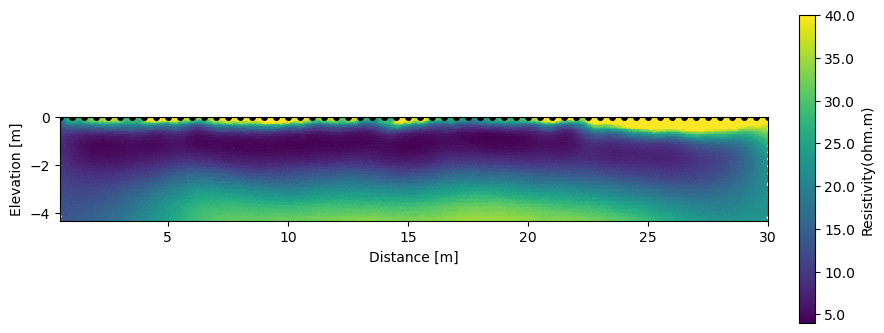

In [26]:
# inverted transect
fig, ax = plt.subplots(figsize=(10, 4))
kp.showResults(ax=ax, attr='Resistivity(ohm.m)', sens=False, vmin=4, vmax=40)

fig.savefig(ERTdatadir + 'proefhoeve-inv-ERT-'+'.jpg', dpi=300)

In [27]:
# extract profiles
mp = kp.meshResults[0]
pd.set_option('display.max_rows', None)

dfsp = []
for i in range(dfp.shape[0]):
    row = dfp.loc[i, :] # Each row of the original ERT positions
    mask = mp.df['X'].between(row['distance'] - extract, row['distance'] + extract) & mp.df['Z'].gt(-5) # Mask for each element of the ERT 
    sdf = mp.df[mask][['Z', 'Resistivity(ohm.m)']] # Depth and resistivity of the filtered elements
    sdf['Z'] = sdf['Z'].round(1)
    sdf = sdf.groupby('Z').mean().reset_index() # Take the mean
    sdf['easting'] = row['easting']
    sdf['northing'] = row['northing']
    sdf['ID'] = row['ID'] # After taking the mean, each profile is set in the original ID
    dfsp.append(sdf)
dfpi = pd.concat(dfsp)
dfpi.to_csv(ERTdatadir + 'proefhoeve-inv-ERT-'+str(extract)+'.csv', index=False)

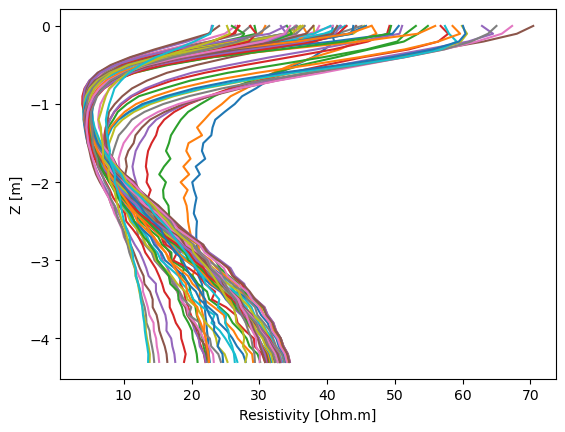

In [28]:
# figure of profiles
fig, ax = plt.subplots()
for el in dfpi['ID'].unique():
    ie = dfpi['ID'].eq(el)
    ax.plot(dfpi[ie]['Resistivity(ohm.m)'], dfpi[ie]['Z'], '-')
ax.set_xlabel('Resistivity [Ohm.m]')
ax.set_ylabel('Z [m]')
fig.savefig(ERTdatadir + 'proefhoeve-prof'+str(extract)+'.jpg')